# Higgs Boson detection

In [1]:
%matplotlib inline
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
from expansion import *
%load_ext autoreload
%autoreload 2
import pandas as pd
from IPython.display import display
from proj1_helpers import *

## Data parsing/cleaning

In [2]:
pri0_to_drop = ["DER_deltaeta_jet_jet","DER_mass_jet_jet","DER_prodeta_jet_jet","DER_lep_eta_centrality","PRI_jet_leading_pt","PRI_jet_leading_eta","PRI_jet_leading_phi","PRI_jet_subleading_pt","PRI_jet_subleading_eta","PRI_jet_subleading_phi"]
pri1_to_drop = ["DER_deltaeta_jet_jet","DER_mass_jet_jet","DER_prodeta_jet_jet","DER_lep_eta_centrality","PRI_jet_subleading_pt","PRI_jet_subleading_eta","PRI_jet_subleading_phi"]

In [3]:
DATA_TRAIN_PATH = '../data/train.csv'
hb = pd.read_csv(DATA_TRAIN_PATH, sep=',')
pd.options.display.max_columns = None
hb = hb.drop(['Id'], 1)

def cleanDataSet(dataset):
    #dataset = add_DER_mass_indicator(dataset)
    dataset_mass_def = dataset[dataset.DER_mass_MMC != -999].copy()
    dataset_mass_not_def = dataset[dataset.DER_mass_MMC == -999].copy()
    dataset_mass_not_def = dataset_mass_not_def.drop(['DER_mass_MMC'],1)
    def splitOnJetNum(dataset, DER_mass_MMC_is_defined):
        dataset = dataset.replace(-999, np.nan)
        if(DER_mass_MMC_is_defined):
            dataset = nonPolyFeatureExpansion(dataset)


        pri0 = dataset[dataset.PRI_jet_num==0].copy()
        pri0 = pri0.drop(pri0_to_drop,1)
        pri0 = pri0.drop(["PRI_jet_num","PRI_jet_all_pt"],1)

        pri1 = dataset[dataset.PRI_jet_num == 1].copy()
        pri1 = pri1.drop(pri1_to_drop,1)
        pri1 = pri1.drop(["PRI_jet_num"],1)

        pri2 = dataset[dataset.PRI_jet_num == 2].copy()
        pri2 = pri2.drop(["PRI_jet_num"],1)

        pri3 = dataset[dataset.PRI_jet_num == 3].copy()
        pri3 = pri3.drop(["PRI_jet_num"],1)

        return [pri0,pri1,pd.concat([pri2,pri3])]
    
    return splitOnJetNum(dataset_mass_def, True) + splitOnJetNum(dataset_mass_not_def, False)

def extractPredictions(dataset):
    return dataset.Prediction.apply(lambda x: -1 if x == 'b' else 1).to_numpy()

def add_DER_mass_indicator(data):
    data['DER_mass_MMC_present'] = (data.DER_mass_MMC == -999).apply(lambda x : 1 if x else 0)
    return data

def nonPolyFeatureExpansion(data):
    data['Mass_let_tau_sum_pt_ratio'] = data.DER_mass_MMC * data.DER_pt_ratio_lep_tau / (data.DER_sum_pt+1e-10)
    return data

def normalizeDataset(dataset):
    dataset = (dataset - dataset.mean()) / dataset.std()
    dataset = dataset.fillna(0)
    dataset = (dataset - dataset.mean()) / dataset.std()
    return dataset

def normalizeDataset_numpy(dataset):
    dataset = (dataset - dataset.mean(axis=0)) / dataset.std(axis=0)
    dataset = np.nan_to_num(dataset)
    dataset = (dataset - dataset.mean(axis=0)) / dataset.std(axis = 0)
    return dataset

def tildaNumpy(X):
    return np.c_[np.ones(X.shape[0]), X]

POLYNOMIAL_EXPANSION_DEGREE = 13

tx = cleanDataSet(hb)
y = []

for idx, dataset in enumerate(tx):
    y.append(extractPredictions(dataset))
    dataset = dataset.drop(['Prediction'],1)
    tx[idx] = tildaNumpy(normalizeDataset_numpy(polynomial_expansion( normalizeDataset(dataset).to_numpy(), POLYNOMIAL_EXPANSION_DEGREE)))

In [4]:
from implementations import *

number_of_algorithms = 6

w = []
for i in range(number_of_algorithms):
    w.append([])

initial_w = [np.zeros(txi.shape[1]) for txi in tx]

## Algorithms

### 0. Least squares gradient descent

In [5]:
algorithm = 0
w[algorithm] = []
for i, (yi, txi, wi) in enumerate(zip(y, tx, initial_w)):
    local_w, loss = least_squares_GD(yi, txi, wi, 1000, 1e-3)
    w[algorithm].append(local_w)
    print(loss)

0.32139693355552773
0.371194518822772
0.35953288361445246
0.14410647534306145
0.1868179284160597
0.1926761296452721


### 1. Least squares stochastic gradient descent

In [6]:
algorithm = 1
w[algorithm] = []
for yi, txi, wi in zip(y, tx, initial_w):
    local_w, loss = least_squares_SGD(yi, txi, wi, 10000, 1e-3)
    w[algorithm].append(local_w)
    print(loss)

0.3213598194328293
0.37116646799875674
0.35950366450012333
0.1439584669196012
0.18662889074941325
0.19251163771670746


### 2. Least squares

In [7]:
algorithm = 2
w[algorithm] = []
for yi, txi in zip(y, tx):
    local_w, loss = least_squares(yi, txi)
    w[algorithm].append(local_w)
    print(loss)

0.2720999044174108
0.30491524455679014
0.3776063451479699
0.08194834101162973
0.1368292790205742
0.12672619126663648


### 3. Ridge regression

0.006210169418915616


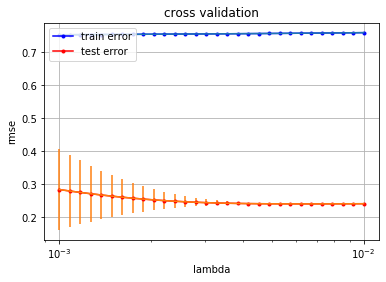

0.003562247890262444


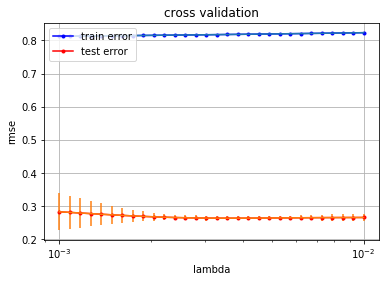

0.00032903445623126676


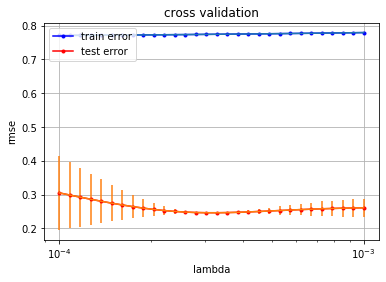

0.06210169418915616


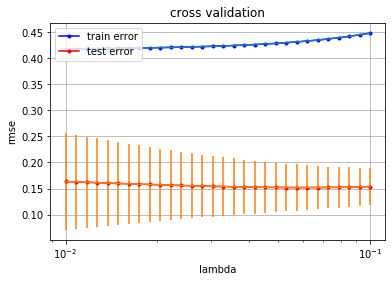

0.0028072162039411755


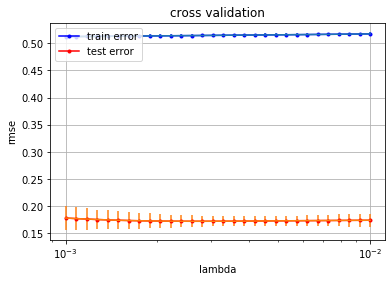

0.04893900918477494


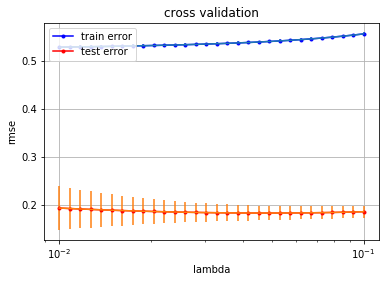

In [8]:
from plots import *

ridge_parameters = []

def build_k_indices(y, k_fold, seed):
    """build k indices for k-fold."""
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval]
                 for k in range(k_fold)]
    return np.array(k_indices)

def cross_validation(y, x, k_indices, k, lambda_):
    """return the loss of ridge regression."""

    x_tr = np.delete(x, k_indices[k], axis=0)
    y_tr = np.delete(y, k_indices[k], axis=0)
    
    x_te = x[k_indices[k]]
    y_te = y[k_indices[k]]
    w, rmse = ridge_regression(y_tr, x_tr, lambda_)
    
    n = y.shape[0]
    loss_tr = rmse
    loss_te = compute_loss_rmse(2*n , compute_e(y_te, x_te, w))
    return loss_tr, loss_te
    
def cross_validation_demo(i):
    seed = 2019
    k_fold = 10
    lambdas = np.logspace(-10, -3, 15)
    if i == 0:
        lambdas = np.logspace(-3, -2, 30)
    elif i == 1:
        lambdas = np.logspace(-3, -2, 30)
    elif i == 2:
        lambdas = np.logspace(-4, -3, 30)
    elif i == 3:
        lambdas = np.logspace(-2, -1, 30)
    elif i == 4:
        lambdas = np.logspace(-3, -2, 30)
    elif i == 5:
        lambdas = np.logspace(-2, -1, 30)
    
    yex = y[i][:,np.newaxis]
    x = tx[i]
    
    # split data in k fold
    k_indices = build_k_indices(yex, k_fold, seed)
    # define lists to store the loss of training data and test data
    rmse_tr = []
    rmse_te = []
    var_tr = []
    var_te = []
    
    for lambda_ in lambdas:
        loss_tr = []
        loss_te = []
        for k in range(k_fold):
            tr, te = cross_validation(yex, x, k_indices, k, lambda_)
            loss_tr.append(tr)
            loss_te.append(te)
        rmse_tr.append(np.mean(loss_tr))
        rmse_te.append(np.mean(loss_te))
        var_tr.append(np.std(loss_tr))
        var_te.append(np.std(loss_te))
    optimal = lambdas[np.argmin(rmse_te)]
    print(optimal)
    ridge_parameters.append(optimal)
    cross_validation_visualization(lambdas, rmse_tr, rmse_te, var_tr, var_te)

for i in range(len(tx)):
    cross_validation_demo(i)

In [9]:
algorithm = 3
w[algorithm] = []
for yi, txi, ridge_parameter in zip(y, tx, ridge_parameters):
    local_w, loss = ridge_regression(yi, txi, ridge_parameter)
    w[algorithm].append(local_w)
    print(loss)

0.757572786776236
0.8181975593660928
0.7745536334242282
0.43275341587260346
0.5148865812179867
0.5407956516331069


### 4. Logistic regression

In [10]:
algorithm = 4
w[algorithm] = []
gamma = 0.1
for yi, txi, wi in zip(y, tx, initial_w):
    losses = []
    yi = (yi+1)/2
    local_w, loss = logistic_regression(yi, txi, wi.copy(), 100000, gamma) 
    w[algorithm].append(local_w)
    print(loss)

75939.12338498449
127198.36884224544
155022.42692999382
12741.386052927577
8571.778302091534
5536.126105547543


### 5. Regularized logistic regression

In [11]:
algorithm = 5
w[algorithm] = []
gamma = 0.1
lambda_ = 0.001
for yi, txi, wi in zip(y, tx, initial_w):
    yi = (yi+1)/2
    local_w, loss = reg_logistic_regression(yi, txi, lambda_, wi, 1000, gamma)
    w[algorithm].append(local_w)
    print(loss)

433170.26571384526
488105.7025541797
380248.5781669086
39033.11653962625
13530.626074803542
10018.656288199754


### Load test set

In [12]:
DATA_TEST_PATH = '../data/test.csv'

hbt = pd.read_csv(DATA_TEST_PATH, sep=',')
hbt = hbt.drop(['Prediction'], 1)
hbt = hbt.set_index(['Id'])

## Make predictions

In [13]:
output_algo = 5

test_pri = cleanDataSet(hbt)
test_pri_tX = [] # tX arrays to run prediction on
for idx , dataset in enumerate(test_pri):
    test_pri_tX.append( tildaNumpy(normalizeDataset_numpy(polynomial_expansion( normalizeDataset(dataset).to_numpy(), POLYNOMIAL_EXPANSION_DEGREE))))
    
def predict(test_pri,test_pri_tX, w):
    for idx, dataset in enumerate(test_pri_tX):
        test_pri[idx]['Prediction'] = predict_labels(w[output_algo][idx],dataset)
    return test_pri

test_prediction = predict(test_pri,test_pri_tX,w)
test_prediction = pd.concat(test_prediction,sort=True)
test_prediction = test_prediction.sort_index()
OUTPUT_PATH = 'predictions.csv'
create_csv_submission(test_prediction.Prediction.keys(), test_prediction.Prediction.values, OUTPUT_PATH)

In [14]:
print(len(test_prediction.Prediction.values))
print(len(test_prediction.Prediction.values[test_prediction.Prediction.values > 0]))

568238
185728


In [15]:
print(w[4][0].shape)

(248,)
